In [1]:
%reset -f
from pythonrc import *

In [2]:
time_step = 1.0

actuators = [tunnel, voithschneider_port, voithschneider_starboard]
force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [1e-2, 1e-2, 1e-2]
mu = [1e-1, 1e-1, 1e-1]
rho = [1.0e1, 1.0e1, 1.0e1]
zeta = [2.0e1, 2.0e1, 2.0e1]
lambda_p = [0.99, 0.5, 0.0]
markdown_table = generate_markdown_table(
    gamma, mu, rho, zeta, lambda_p,
)
display(Markdown(markdown_table))

| | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ |
|--|-------|----|-----|------|----------|
| Run 0| 0.01 | 0.1 | 10.0 | 20.0 | 0.99 |
| Run 1| 0.01 | 0.1 | 10.0 | 20.0 | 0.5 |
| Run 2| 0.01 | 0.1 | 10.0 | 20.0 | 0.0 |


In [3]:

for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):

    allocators.append(
        skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
            actuators=actuators,
            force_torque_components=force_torque_components,
            gamma=g,
            mu=m,
            rho=r,
            time_step=time_step,
            lambda_=l,
            zeta=z,
        )
    )

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$F_x$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [N]'>], dtype=object))

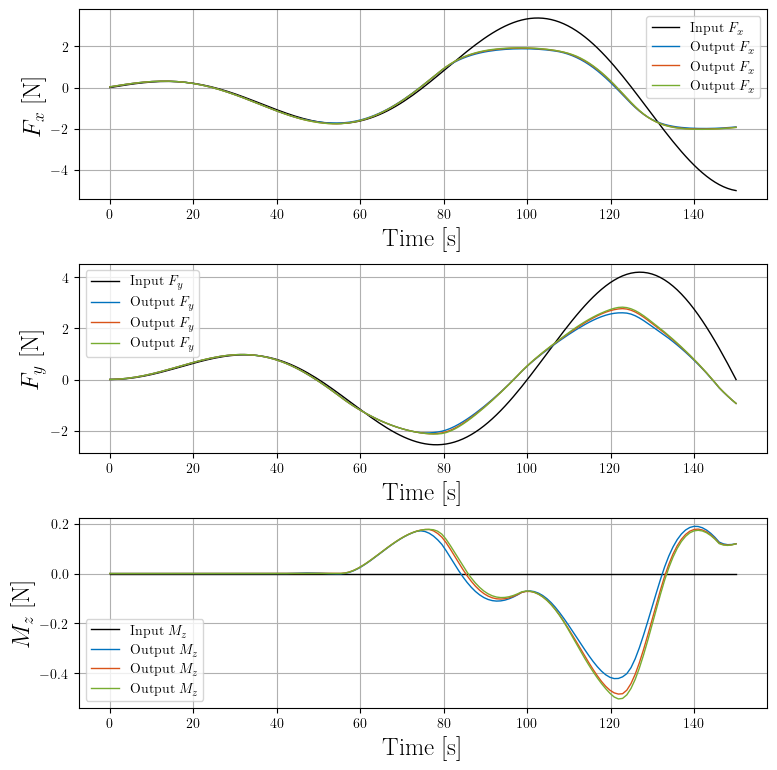

In [4]:
data = generate_spiral_dataset(
    num_points=150,
    num_turns=1.5,
    k=5
)

tau_cmd = np.concatenate(
    (data, np.zeros((np.shape(data)[0], 4))),
    axis=1
)
d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist, dt=time_step)

(<Figure size 800x800 with 2 Axes>,
 array([<Axes: xlabel='$F_x$ [N]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [Nm]'>], dtype=object))

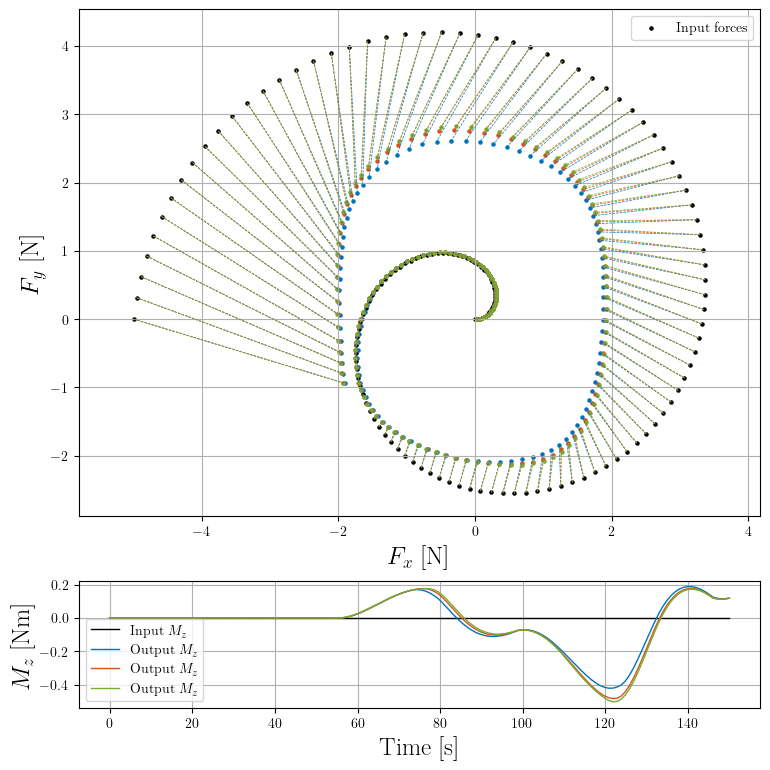

In [5]:
plot_2d_allocation(tau_cmd=tau_cmd, allocators=allocators, tau_hist=tau_hist)


(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='Tunnel [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Port [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Starboard [N]'>], dtype=object))

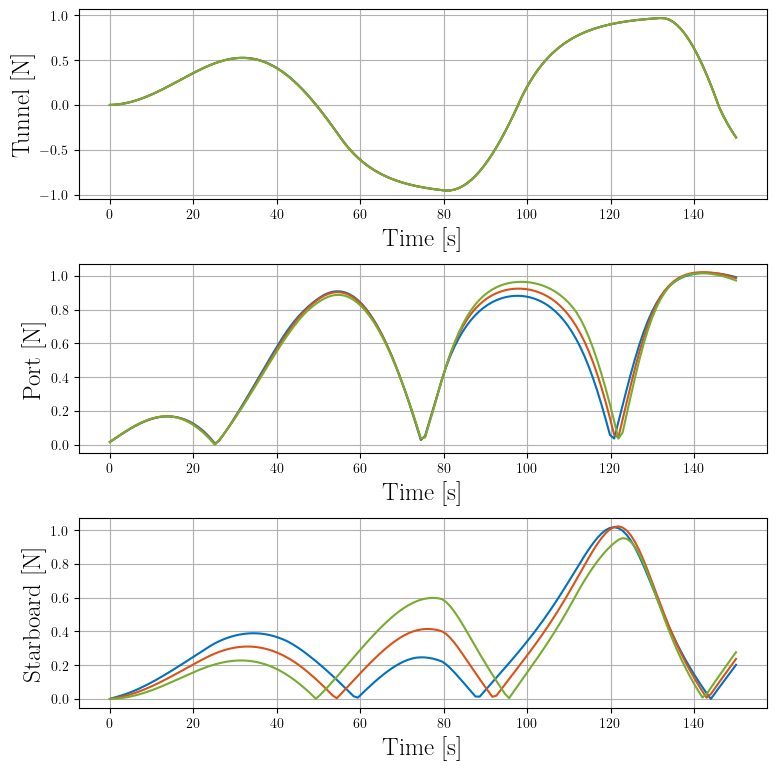

In [6]:
plot_thruster_forces(xi_hist, dt=time_step)

(<Figure size 800x800 with 1 Axes>,
 <Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>)

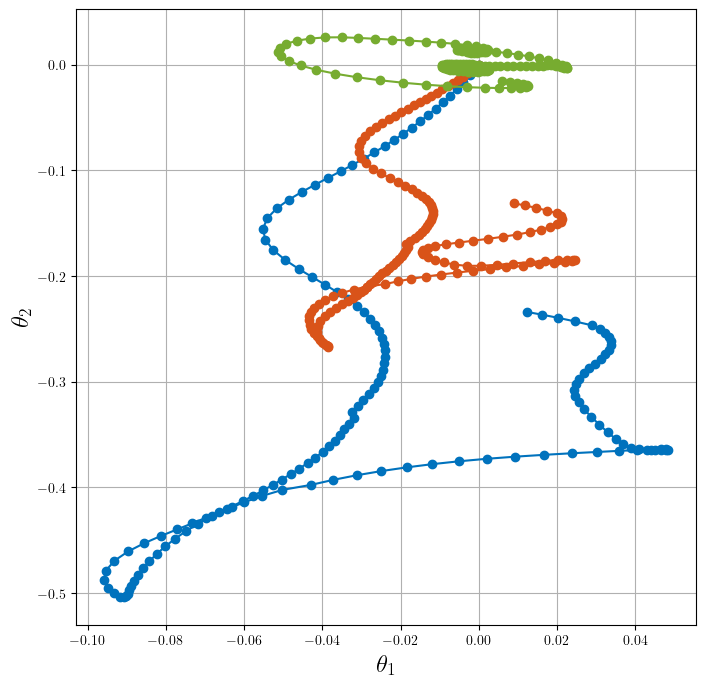

In [7]:
plot_theta_histories(theta_hist=theta_hist)

In [8]:
save_mat(
    filename="data/011.mat",
    dt=time_step,
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)